In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
production = pd.read_sas('C:/Users/kucza/OneDrive/Desktop/DataScience/CreditScoringPython/dane/production.sas7bdat',
                        format = 'sas7bdat',
                         encoding="ISO-8859-1" )
transactions = pd.read_sas('C:/Users/kucza/OneDrive/Desktop/DataScience/CreditScoringPython/dane/transactions.sas7bdat',
                        format = 'sas7bdat',
                         encoding="ISO-8859-1" )

In [29]:
production.head()

,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,act_CIns_All5y,act_CAll_Acp5y,act_CAll_All5y,APP_CHAR_GENDER,APP_CHAR_CITY,APP_CHAR_BRANCH,APP_CHAR_JOB_CODE,APP_CHAR_CARS,APP_CHAR_HOME_STATUS,APP_CHAR_MARITAL_STATUS
0,0000001237,css2006010100123,css,200601,84.0,0.577685,2.606882,1918.0,5000.0,24.0,...,1.0,7.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,2.0
1,0000003380,css2006010100350,css,200601,87.0,0.499747,2.529084,1977.0,5000.0,24.0,...,NaN,14.0,15.0,1.0,3.0,0.0,4.0,0.0,0.0,1.0
2,0000003467,css2006010100357,css,200601,75.0,0.584158,4.125413,1212.0,5000.0,24.0,...,1.0,16.0,16.0,1.0,1.0,0.0,4.0,1.0,0.0,1.0
3,0000003620,css2006010100367,css,200601,94.0,0.602687,4.798464,1042.0,5000.0,24.0,...,NaN,14.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0
4,0000003621,css2006010100368,css,200601,70.0,0.604592,3.188776,1568.0,5000.0,24.0,...,NaN,15.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


In [31]:
transactions.head()

,cid,aid,product,period,fin_period,status,due_installments,paid_installments,leftn_installments
0,0000000002,css2006010500001,css,200601,200601,A,0.0,0.0,24.0
1,0000000002,css2006010500001,css,200602,200601,A,0.0,1.0,23.0
2,0000000002,css2006010500001,css,200603,200601,A,0.0,2.0,22.0
3,0000000002,css2006010500001,css,200604,200601,A,0.0,3.0,21.0
4,0000000002,css2006010500001,css,200605,200601,A,0.0,4.0,20.0


Default definition: if a product ever has n_installments_due or more it is considered as default, no matter if the client pays the loan back at a later time.

In [3]:
def MaxDueInstallmentsMinPeriod(data_transactions):
    #Creating table with product id, first installment period adn max due installements.
    max_due_install_min_period = pd.pivot_table(data = data_transactions, index = 'aid',
                                            values = ['due_installments', 'period'], aggfunc = ['max', 'min'])
    max_due_install_min_period.columns = ['max_due_installments', 'max_period', 'min_due_installments', 'min_period']
    max_due_install_min_period.drop(['max_period', 'min_due_installments'], axis = 1, inplace = True)
    max_due_install_min_period['min_period'] = pd.to_numeric(max_due_install_min_period['min_period'])
    return max_due_install_min_period

def DefaultPerProduct(data_product, n_installments_due = 3, max_period = 200712):
    #Creating dataframe with 0-1 variable if the product defaulted
    col_name = 'default'+str(n_installments_due)
    data_product.insert(len(data_product.columns),col_name, 0)
    for index, row in data_product.iterrows():        
        if row['max_due_installments'] >= n_installments_due and row['min_period'] <= max_period:
            data_product.at[index, col_name] = 1
        else:
            data_product.at[index, col_name] = 0
    data_product.drop(['min_period', 'max_due_installments'], axis = 1, inplace = True)
    return data_product

def ProductionDefault(data_product_default, data_production):
    #Adding col1umn with 0-1 default to the main dataframe
    data_production['period'] = pd.to_numeric(data_production['period'])
    data_production = data_production[data_production['period'] <= 200712]
    data_merged = data_production.merge(right = data_product_default, on = 'aid')
    return data_merged

def unique_count(dataframe):
    uniques = dataframe.from_records([(col, dataframe[col].nunique()) for col in dataframe.columns], 
                                        columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
    return uniques

def DeleteMissing(dataframe, perc_missing_delete = 0.6):
    return_df = dataframe[dataframe.columns[dataframe.isnull().mean() <= perc_missing_delete]]
    return return_df

In [4]:
data = MaxDueInstallmentsMinPeriod(transactions)

In [5]:
def_product = DefaultPerProduct(data, 3, 200712)

In [6]:
data_merged = ProductionDefault(def_product, production)

In [9]:
data_merged_nomisscol = DeleteMissing(data_merged, 0.6)

In [19]:
data_css = data_merged_nomisscol[data_merged_nomisscol['product'] == 'css'].copy()

In [33]:
data_css_select = data_css.iloc[:,5:29]

In [37]:
data_css_default3 = data_css.loc[:,'default3'].values

In [34]:
data_css_select.head()

,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,act_call_cc,act_cins_n_loan,...,act_cins_n_loans_hist,act_cins_n_statC,act_cins_n_statB,act_ccss_seniority,act_ccss_min_seniority,act_ccss_n_loans_hist,act_ccss_n_statC,act_ccss_n_statB,act_cus_active,act_CMaxA_Days
0,0.577685,2.606882,1918.0,5000.0,24.0,0.0,900.0,208.0,1.119917,0.0,...,21.0,21.0,0.0,307.0,4.0,51.0,43.0,2.0,1.0,15.0
1,0.499747,2.529084,1977.0,5000.0,24.0,0.0,780.0,208.0,1.025797,0.0,...,9.0,6.0,3.0,252.0,4.0,40.0,32.0,2.0,1.0,14.0
2,0.584158,4.125413,1212.0,5000.0,24.0,0.0,500.0,208.0,1.442244,0.0,...,6.0,6.0,0.0,309.0,4.0,76.0,70.0,0.0,1.0,14.0
3,0.602687,4.798464,1042.0,5000.0,24.0,0.0,420.0,208.0,1.401152,0.0,...,11.0,11.0,0.0,299.0,4.0,69.0,62.0,2.0,1.0,15.0
4,0.604592,3.188776,1568.0,5000.0,24.0,0.0,740.0,208.0,1.267857,0.0,...,11.0,11.0,0.0,307.0,4.0,69.0,62.0,1.0,1.0,14.0


In [39]:
data_css_select.isna().sum()

act_cc                       0
act_loaninc                  0
app_income                   0
app_loan_amount              0
app_n_installments           0
app_number_of_children       0
app_spendings                0
app_installment              0
act_call_cc                  0
act_cins_n_loan              0
act_ccss_n_loan              0
act_call_n_loan              0
act_cins_seniority           0
act_cins_min_seniority       0
act_cins_n_loans_hist        0
act_cins_n_statC             0
act_cins_n_statB             0
act_ccss_seniority        3276
act_ccss_min_seniority    3276
act_ccss_n_loans_hist     3276
act_ccss_n_statC          3276
act_ccss_n_statB          3276
act_cus_active               0
act_CMaxA_Days             414
dtype: int64

In [10]:
data_merged_nomisscol.head()

,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,act_CAll_Acp5y,act_CAll_All5y,APP_CHAR_GENDER,APP_CHAR_CITY,APP_CHAR_BRANCH,APP_CHAR_JOB_CODE,APP_CHAR_CARS,APP_CHAR_HOME_STATUS,APP_CHAR_MARITAL_STATUS,default3
0,0000001237,css2006010100123,css,200601,84.0,0.577685,2.606882,1918.0,5000.0,24.0,...,7.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,2.0,0
1,0000003380,css2006010100350,css,200601,87.0,0.499747,2.529084,1977.0,5000.0,24.0,...,14.0,15.0,1.0,3.0,0.0,4.0,0.0,0.0,1.0,0
2,0000003467,css2006010100357,css,200601,75.0,0.584158,4.125413,1212.0,5000.0,24.0,...,16.0,16.0,1.0,1.0,0.0,4.0,1.0,0.0,1.0,0
3,0000003620,css2006010100367,css,200601,94.0,0.602687,4.798464,1042.0,5000.0,24.0,...,14.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,0
4,0000003621,css2006010100368,css,200601,70.0,0.604592,3.188776,1568.0,5000.0,24.0,...,15.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0,0


In [173]:
data_merged_nomiss.isna().mean().sort_values(ascending=False)

agr3_Mean_CMaxA_Due     0.588670
agr3_Max_CMaxA_Due      0.588670
agr3_Min_CMaxA_Due      0.588670
act_CMaxA_Days          0.587548
act_cus_active          0.582405
                          ...   
APP_CHAR_BRANCH         0.000000
APP_CHAR_JOB_CODE       0.000000
APP_CHAR_CARS           0.000000
APP_CHAR_HOME_STATUS    0.000000
cid                     0.000000
Length: 85, dtype: float64

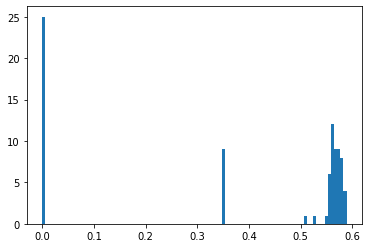

In [174]:
plt.hist(data_merged_nomiss.isna().mean().sort_values(ascending=False), bins=100)
plt.show()

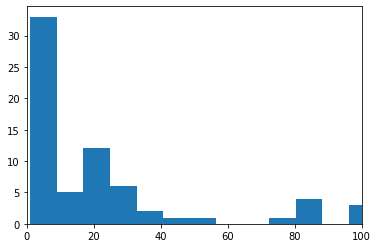

In [14]:
plt.hist(x = unique_count(data_merged_nomiss)['Num_Unique'], bins = 10000)
plt.xlim(0, 100)
plt.show()

In [162]:
len(data_merged)

79328